# Optimize it! EPGs in Python

## 1. Get Tutorial-code repository
- do 'git clone' to get the notebook for the ESMRMB25 session: [GitHub - mrphysics-bonn/epg-tutorial: EPG python code and notebooks for educational purposes](https://github.com/mrphysics-bonn/epg-tutorial)
- `epgOptimization_esmrmb25.ipynb`: Notebook with tutorial code, which uses functions of `epg_code.py`:
    - `pg_plot()` - standalone python function to plot phase graphs
    - `basic_epg()` - a pure python class for basic EPG calculations (sufficient to run tutorial code)

## 2. Installation of EPGpp (C++) & pyepg (python wrapper) - optional, but 1000 times faster than pure python class

- visit mrphysics-bonn Github page: [GitHub - mrphysics-bonn/EPGpp: EPGpp: C++ implementation of Extended Phase Graphs with Cython wrapper](https://github.com/mrphysics-bonn/EPGpp)
- install `pyepg` (python wrapper for a fast cpp implementation of EPGs) with 'pip'
- the code will use `pyepg` if it is installed; otherwise it will use the pure python class `basic_epg`\
Both classes have the same functionality, but `pyepg` is approximately **1000 times faster** than `basic_epg`.


## 3. Introduction to pyepg

### Import standard python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as opt
from datetime import datetime

### Import pyepg or basic_epg if pyepg is not available

In [2]:
# import phase graph plotting function
from epg_code import pg_plot

# import EPG class
# if available import fast pyepg, otherwise use basic_epg
import importlib.util
pyepg_spec  = importlib.util.find_spec("pyepg")
pyepg_found = pyepg_spec is not None

if pyepg_found:
    import pyepg
else:
    from epg_code import basic_epg
    print('module pyepg not found ... continue with slower basic_epg module')

%load_ext autoreload
%autoreload 2

### Signal calculation with EPG

#### Use the constructor of the epg class to create an EPG instance

In [3]:
# creating an EPG instance requires tissue parameters (M0,T1,T2) and a fixed TR

M0   = 1.0
T1   = 800.0
T2   = 50.0
TR   = 10.0

# use basic_epg class if pyepg is not available
EPG = basic_epg(M0, T1, T2, TR) if not pyepg_found else pyepg.PyEPG(M0, T1, T2, TR) 

#### Perform one step in the EPG
1. RF pulse flips magnetization with flip angle `fa` (in degree) and phase `ph` (in degree) from the x-axis
2. constant dephasing by gradient + $T_1$ and $T_2$ decay (recovery for $Z_0$)

We can get the magnetization (real and imaginary part) directly before and directly after the RF pulse and in every state, that is present (here: state=k=0 contains the flipped magnetization in -y direction directly after the 90° pulse).

In [4]:
EPG.Step(fa=90,ph=0)
k=0
print(' Fa(k=%2d) [Real,Imag] = [%5.2f,%5.2f]' % (k,EPG.GetReFa(num=k),EPG.GetImFa(num=k)) , end='')
print(' | Za(k=%2d) [Real,Imag] = [%5.2f,%5.2f]' % (k,EPG.GetReZa(num=k),EPG.GetImZa(num=k)) )

 Fa(k= 0) [Real,Imag] = [ 0.00,-1.00] | Za(k= 0) [Real,Imag] = [ 0.00, 0.00]


## 4. Optimization of FA-train to get target signal-shape

In [5]:
def vfa_tse_signal_shaping(EPG,N,first_fa,shape):
    """
    find variable refocusing flip-angles for TSE signal shaping 
    
    Input
    EPG          : an EPG instance (from pyepg or basic_epg classes)
    N            : echo train length N
    first_fa     : first refocusing FA
    shape        : target signal shape (length N vector)
    Returns
    (signal,vfa) : signal and vFAs (length N vectors)
    """

    # function to minimize with opt.minimize_scalar
    def signal_delta(fa,target):
            return np.abs(target-EPG.GetNextMagFa(fa=fa,ph=90,num=-1)) # phase =90, state number = -1 (ECHO)

    shape /= shape[0]         # normalize shape to first sample
    signal = np.zeros((N,))   # tse signal train
    vfa    = np.zeros((N,))   # variable refocusing flip-angles 
    vfa[0] = first_fa
    EPG.Equilibrium()
    EPG.Step(fa=90      ,   ph=0 ) # excitation around x-axis
    EPG.Step(fa=first_fa, ph=90)   # refocusing around y-axis
    EPG.Step(0,0)                  # evolve TE/2 
    signal[0]=EPG.GetMagFa()       # first spin echo
    for i in range(1,N):
        target = signal[0]*shape[i]*np.exp(EPG.GetTR()/EPG.GetT2()) # target signal has to be corrected for decay of one TR
        # find FA for which state F_{-1} gets closest to the target signal
        res    = opt.minimize_scalar(signal_delta,bounds=(0,180),args=(target,),options={'xatol':1e-5})
        vfa[i] = res.x
        EPG.Step(fa=vfa[i],ph=90)  # apply FA (refocusing around y-axis)
        EPG.Step(fa=0,ph=0)        # evolve TE/2
        signal[i]=EPG.GetMagFa()   # spin echo
    return (signal,vfa)

def get_shape(shape_type,N,a=0.1,b=1,c=2,d=16,e=1,f=4):
    """
    generate target shapes for vFA signal shaping

    Four different shapes are supported as proposed by Busse et al [1]

    Input
    shape_type  : one of 'lin', 'exp', 'exp+lin', 'lin+exp+lin', otherwise the shape is constant
    N           : number of sample points (= echo train length)
    a,b,c,d,e,f : shaping parameters
                  a -> slope for 'lin' and for the linear part in 'exp+lin' and 'exp+lin+exp'
                  b -> constant offset for all types (larger b flattens the shape)
                  c -> exponential decay for 'exp' and for the (first) exponential part of 'exp+lin' (and for 'exp+lin+exp')
                  d -> fraction of samples for the (first) exponential part of 'exp+lin' (and for 'exp+lin+exp')  
                  e -> exponential decay for the second exponential part of 'exp+lin+exp'
                  f -> fraction of samples for the second exponential part of 'exp+lin+exp'

    [1] R. F. Busse et al., “Effects of refocusing flip angle modulation and view ordering in 3D fast spin echo.,” Magnetic resonance in medicine : official journal of the Society of Magnetic Resonance in Medicine / Society of Magnetic Resonance in Medicine, vol. 60, no. 3, pp. 640–9, Sep. 2008, doi: 10.1002/mrm.21680.
    """
    match shape_type:
        case 'lin':
            shape = -a*np.linspace(0,1,N)+b 
        case 'exp':
            shape = np.exp(-c*np.linspace(0,1,N))+b
        case 'exp+lin':
            exp   = np.exp(-c*np.linspace(0,1,N//d))+b
            lin   = -a*np.linspace(0,1,N-len(exp)+1)+exp[-1]
            shape = np.hstack((exp[:-1],lin))
        case 'exp+lin+exp':
            exp1  = np.exp(-c*np.linspace(0,1,N//d))+b
            exp2  = np.exp(-e*np.linspace(0,1,N//f))-1
            lin   = -a*np.linspace(0,1,N-len(exp1)-len(exp2)+2)+exp1[-1]
            shape = np.hstack((exp1[:-1],lin[:-1],exp2+lin[-1]))
        case _:
            shape = np.ones((N,)) 
    shape /= shape[0]   # normalize shape to first sample
    return shape

def plot_sig_vfa(s,b,TE,M0,TITLE='vFA-TSE signal shaping'):
    N=len(s)
    plt.plot(np.linspace(1,N,N),100/M0*np.abs(s),'r')
    plt.xlabel('echo number')
    plt.ylabel('signal / [%$M_0$]',color='r')
    plt.ylim( (95*np.min(np.abs(s)),105*np.max(np.abs(s))) )
    ax2 = plt.twinx()
    ax2.plot(np.linspace(1,N,N),b,'b')
    ax2.set_ylabel('flip angle / [deg]',color='b')
    ax2.set_ylim((0,180))
    ax3 = plt.twiny()
    ax3.plot(np.linspace(TE,N*TE,N),b,'b')
    ax3.set_xlabel('echo time / [ms]')
    plt.title(TITLE)
    plt.show()


1. `EPG.Equilibrium()`: Start with equilibrium magnetization
2. `EPG.Step(fa=90      ,   ph=0 )`: Go one step by applying 90° pulse with phase=0° + decay and dephasing during TE/2
3. `EPG.Step(0,0)`: Since we want the signal after TE/2 and `EPG.GetMagFa()` results in the magnetization **directly after** the pulse, we need to apply a 'dummy pulse' to get the echo
4. `signal[0]=EPG.GetMagFa()`: Obtain spin echo ($F_0$ state)
5. Loop over signal to get the variable flip angle train:
    - `opt.minimize_scalar`: scipy function, which tries to find the flip angle `fa`, which minimizes the difference between the next signal target value and the echo of the next pulse
    - `EPG.Step(fa=vfa[i],ph=90)`: apply refocusing pulse with estimated `fa`
    - `EPG.Step(fa=0,ph=0)`: apply dummy pulse
    - `signal[i]=EPG.GetMagFa()`: get spin echo

### What do we want to optimize?
Compute a variable flip angle train of a TSE-sequence in order to get a specific target shape, i.e. signal magnitudes over successive echoes.

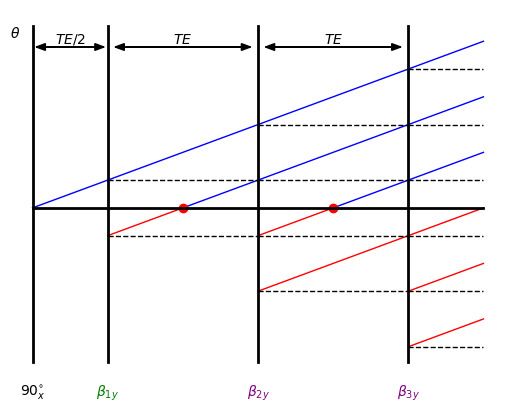

In [6]:
# phase graph of a CPMG sequence
fig, ax = plt.subplots()

# Plot phase graph and return FA-labels and time-labels (2nd and 4th output argument => slice [1:4:2])
(FL,TL)=pg_plot(axis=ax,T=[1,2,2,1],CPMG=True,FA_LABELS=True,TAU_LABELS=True,ECHOES=True,BLACK=False,STATE_LABELS=False)[1:4:2]
# CPMG=True => excitation states from refocusing pulses are not plotted

# Overwrite FA-labels (alpha1,alpha2,...) with suitable text for CPMG
FL[0].set_text(r'90$^{\circ}_x$')
for i in range(1,4):
    if i == 1:
        FL[i].set_text(r'$\beta_{'+str(i)+'y}$')
        FL[i].set_color("green")
    else:
        FL[i].set_text(r'$\beta_{'+str(i)+'y}$')
        FL[i].set_color("purple")

# Overwrite time-labels (tau1,tau2,...) with suitable text for CPMG
TL[0].set_text(r'$TE/2$')
for i in range(1,3): TL[i].set_text(r'$TE$')

plt.show()

**s: red echo train of the TSE sequence**

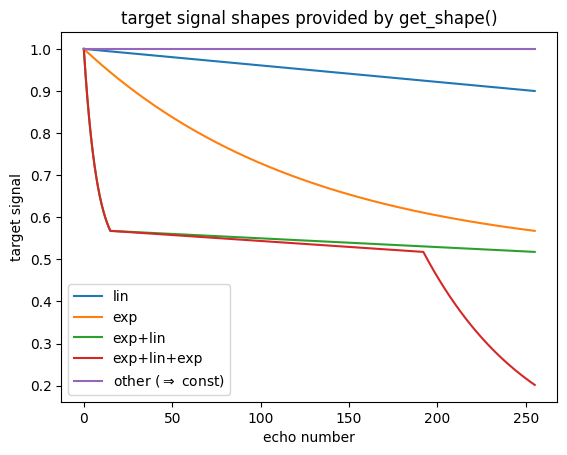

In [7]:
for shape_type in ['lin','exp','exp+lin','exp+lin+exp',r'other ($\Rightarrow$ const)']:
    plt.plot(get_shape(shape_type=shape_type,N=256),label=shape_type)
plt.legend()
plt.xlabel('echo number')
plt.ylabel('target signal')
plt.title('target signal shapes provided by get_shape()')
plt.show()

### Set EPG to equilibrium state (or create new EPG instance)

In [8]:
M0   = 1.0
T1   = 800.0
T2   = 50.0
TE   = 4.0
N    = 256

EPG.SetParameters(M0, T1, T2, TE/2) # => EPG is in equilibrium state 

shape = get_shape(shape_type='exp+lin+exp',N=N)

### Bisection method
To find the variable flip angle train resulting in the target shape, which also maximizes our signal, we try to find the maximum first refocusing flip angle in the train, that leads to the target shape, with the bisection method.

We try to find the optimal first refocusing flip angle by repeatedly halving an interval and see if the resulting signal, obtained from an optimized flip angle train, minus the target signal shape is below a tolerance limit and if this is the case, the current flip angle is set to the lower bound and if not, it is set to the upper bound:

![Bisection method](FAOptimization.png)

done at (j,b_l,b_u,norm)= 14 28.2403564453125 28.245849609375 3.7874656975144414e-08
calculation time: 1064.88 milliseconds



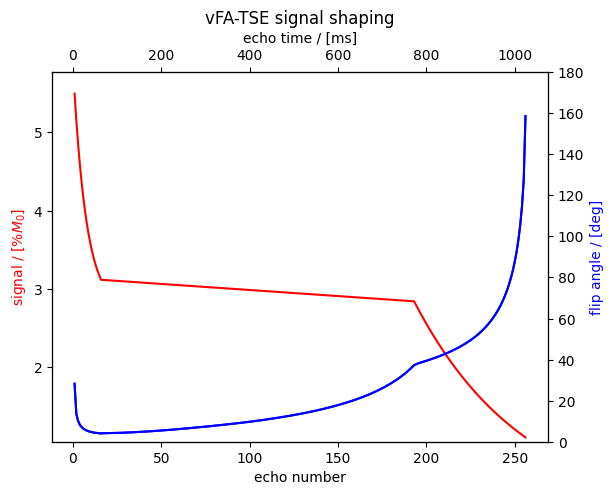

In [9]:
# bisectioning to find the maximum first refocusing flip-angle of the vfa train
start_time = datetime.now()
b_l = 0     #FA lower bound
b_u = 180   #FA upper bound
MI  = 100   #max number of iterations
for j in range(MI):
    # try signal shaping with first FA in the middle of the interval
    first_fa = 0.5*(b_l + b_u)
    (s,b) = vfa_tse_signal_shaping(EPG,N,first_fa,shape)
    # shaping successful?
    if np.linalg.norm(s-s[0]*shape) < 1e-6: 
        b_l = first_fa # yes => set lower bound to first FA
    else:                                   
        b_u = first_fa # no  => set upper bound to first FA
    # stop if upper bound is close to lower bound and if last shaping was successful
    if np.isclose(b_u,b_l,atol=1e-2) and b_l == first_fa:
        print('done at (j,b_l,b_u,norm)=',j,b_l,b_u,np.linalg.norm(s-s[0]*shape))
        break
    if j==MI-1:
        print('did not converge in ',MI,' iterations')
delta1 = datetime.now() - start_time
print('calculation time: %.2f milliseconds\n' % (delta1.total_seconds() * 1000))

plot_sig_vfa(s,b,TE,M0)



### SAR reduction example as proposed by Pracht et al. [2]
- in case of SAR-constraints: multiplicate `first_fa` by a `factor`< 1
- Result: 80% less SAR, only 10% signal loss

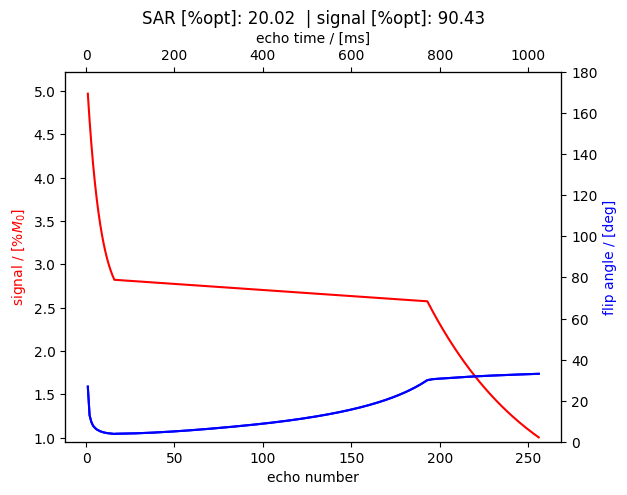

In [10]:
""" 
SAR reduction example as proposed by Pracht et al. [2]

Slightly decreasing the first FA strongly reduces SAR of the vFA train while only slightly reducing the signal level.

[2] E. D. Pracht et al., “SAR and scan-time optimized 3D whole-brain double inversion recovery imaging at 7T,” Magnetic Resonance in Medicine, vol. 79, no. 5, pp. 2620–2628, 2018, doi: 10.1002/mrm.26913.
"""

factor = 0.95 # first FA reduction factor
(sr,br) = vfa_tse_signal_shaping(EPG,N,factor*first_fa,shape)
sar = 100*np.linalg.norm(br**2)/np.linalg.norm(b**2)
sig = 100*np.linalg.norm(sr)/np.linalg.norm(s)

plot_sig_vfa(sr,br,TE,M0,TITLE='SAR [%%opt]: %5.2f  | signal [%%opt]: %5.2f' % (sar,sig))

## 5. Further information
- author: Tony Stöcker (MR Physics, German Center for Neurodegenerative Diseases (DZNE))
- mrphysics-bonn Github page: [GitHub - mrphysics-bonn/EPGpp: EPGpp: C++ implementation of Extended Phase Graphs with Cython wrapper](https://github.com/mrphysics-bonn/EPGpp)
- see more examples in `epg_examples.ipynb` (e.g. steady state signal computation with and without RF spoiling)
- learn more about phase graph plotting with `phase_graphs.ipynb`
- plot the different epg-states as shown in `plot_epg_states.ipynb`